In [70]:
# Final Thesis Report: Sentiment Analysis in Sports and Outdoors Product Reviews Using Machine Learning (September 2024)
# Student: Manh Nguyen Hung

# Content Table
<a id='menu'></a>

1. [Libraries Import](#m-1)
2. [Environment Configuration](#m-2)
2. [Data Reading](#m-3)
3. [Data Understanding](#m-4)
5. [Data Cleansing for EDA](#m-5) \
   5.1 [Data Quality Checks](#m-5-1) \
   5.2 [Fix Rows and Columns](#m-5-2) \
   5.3 [Fix Missing Values](#m-5-3) \
   5.4 [Fix Invalid Values](#m-5-4) \
   5.5 [Filter Data](#m-5-5) \
   5.6 [Result](#m-5-6)
6. [Derived Metrics](#m-6) \
   6.1 [Type-Driven Metrics](#m-6-1) \
   6.2 [Result](#m-6-2)
7. [Data Visualisation (EDA)](#m-7) \
   7.1 [Univariate Analysis](#m-7-1) \
   7.2 [Segmented Univariate Analysis](#m-7-2) \
   7.3 [Bivariate Analysis](#m-7-3)
8. [Data Cleansing after EDA](#m-8) \
   8.1 [Fix rows and Columns](#m-8-1) \
   8.2 [Filter Data](#m-8-2) \
   8.3 [Result](#m-8-3)
9. [Data Preparation](#m-9) \
   9.1 [Combine Text Columns](#m-9-1) \
   9.2 [Result](#m-9-2)
10. [Text Processing](#m-10) \
   10.1 [Prepare The Text for Modelling](#m-10-1) \
   10.2 [Visualize Text after Processing](#m-10-2) \
   10.3 [Result](#m-10-3)
11. [Sentiment Detection](#m-11) \
   11.1 [Calculate Sentiment Scores](#m-11-1) \
   11.2 [Detect Final Sentiment State](#m-11-2) \
   11.3 [Result](#m-11-3)
12. [Feature Extraction](#m-12)
13. [Train-Test Split](#m-13)
14. [Class Imbalanced Classification](#m-14)
15. [Model Building](#m-15) \
   15.1 [Model 1: Logistic Regression](#m-15-1) \
   15.2 [Model 2: Naive Bayes](#m-15-2) \
   15.3 [Model 3: Random Forest](#m-15-3) \
   15.4 [Model 4: XGBoost](#m-15-4)
16. [Compare Models](#m-16)
17. [Save Best Model](#m-17)

# 1. Libraries Import ([menu](#menu)) <a id='m-1'></a>

In [71]:
!pip install -U imbalanced-learn

In [72]:
!pip install xgboost

In [73]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy.sparse as sp
import seaborn as sns
import spacy
import string

from abc import ABC, abstractmethod
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

In [74]:
from imblearn.over_sampling import BorderlineSMOTE

import multiprocessing
from multiprocessing import Manager

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

import pickle
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

import xgboost
from xgboost import XGBClassifier

In [75]:
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# 2. Environment Configuration ([menu](#menu)) <a id='m-2'></a>

In [76]:
# Set True to execute code by using Google Colab
# Set False to execute code by using local computer
USE_COLAB=True

In [77]:
# If Google Colab is used, add google.colab library
if USE_COLAB:
  from google.colab import drive

In [78]:
# If Google Colab is used, mount Google Drive to Colab System
if USE_COLAB:
  drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [79]:
# Define the root path for working directory
root_path = "/content/gdrive/MyDrive/Master-Thesis/master-thesis-sentiment-analysis" if USE_COLAB else '.'

In [80]:
# Define the path for Amazon Reviews 2023 directory
data_path = f"{root_path}/datasets/temp/Amazon Reviews 2023"

# 3. Data Reading ([menu](#menu)) <a id='m-3'></a>

In [81]:
# Define the path for Sports_and_Outdoor dataset
dataset_path = f"{data_path}/Sports_and_Outdoors.jsonl"

In [82]:
# Read first record from dataset
%%time
with open(dataset_path, 'r') as fs:
  first_review = [json.loads(next(fs).strip()) for _ in range(1)]

first_review

CPU times: user 0 ns, sys: 863 ms, total: 863 ms
Wall time: 868 ms


[{'rating': 5.0,
  'title': 'Crazy comfy!',
  'text': 'Not gonna lie- they are not much to look at. Lol. Luckily I’m one of those ppl that values things for function over looks & these function well so far. They are seriously one of the most comfortable pairs of socks I’ve owned in 5 decades.  I have not tried to wash them yet, so fingers crossed on that rn.  They feel very cushiony.  I wear them in my winter boots & just on my feet shoeless around my home.  I wish they came in more colors.  I’m one of those ppl that absolutely cannot stand toe seams on socks, but these have not bothered me at all.  I have super high arches so the only change I would make to the socks would be some compression there.  However, the socks fit perfectly as-is which really surprised me given my arches.  I just like having compression at my arches bc it feels good on them.  I wear a ladies 10-1/2 shoe- mens 8-1/2 and I bought the medium socks. They fit perfectly.  That’s never happened.  I had honestly expe

In [83]:
# Read all records from dataset
%%time
df = pd.read_json(dataset_path, orient="records", lines=True)

CPU times: user 5min 18s, sys: 40.3 s, total: 5min 58s
Wall time: 5min 53s


# 4. Data Understanding ([menu](#menu)) <a id='m-4'></a>

In [84]:
# Print data frame shape
df.shape

(19595170, 10)

In [85]:
# Print data frame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19595170 entries, 0 to 19595169
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   rating             int64         
 1   title              object        
 2   text               object        
 3   images             object        
 4   asin               object        
 5   parent_asin        object        
 6   user_id            object        
 7   timestamp          datetime64[ns]
 8   helpful_vote       int64         
 9   verified_purchase  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 1.3+ GB


In [86]:
# Print data statistics
df.describe()

,rating,timestamp,helpful_vote
count,1.959517e+07,19595170,1.959517e+07
mean,4.218417e+00,2018-11-13 21:26:40.805996800,1.044607e+00
min,1.000000e+00,2000-05-01 19:11:41,-3.000000e+00
25%,4.000000e+00,2016-09-18 23:28:04.500000,0.000000e+00
50%,5.000000e+00,2019-05-06 20:28:12.773000192,0.000000e+00
75%,5.000000e+00,2021-03-19 17:55:59.383000064,0.000000e+00
max,5.000000e+00,2023-09-14 05:40:41.162000,2.878100e+04
std,1.310198e+00,NaN,1.490053e+01


In [87]:
# Print all column names
df.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')

In [88]:
# Print first 5 rows
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Crazy comfy!,Not gonna lie- they are not much to look at. L...,[],B07F3BDT8T,B0BGFR76CF,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2023-02-25 10:30:53.520,8,True
1,5,Excellent!,I love it. Pretty!,[],B00NXQLFQQ,B00NXQLFQQ,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2018-04-07 09:36:11.676,0,True
2,5,Best saddle pads,Huge fan of B Vertigo and this dressage pad do...,[],B08SVPR266,B0957WLR63,AGGZ357AO26RQZVRLGU4D4N52DZQ,2022-05-26 01:01:59.105,0,True
3,5,Perfect repair kit,"I have a great Weaver halter. Recently, the Ch...",[],B00IET8S80,B00IET8S80,AGGZ357AO26RQZVRLGU4D4N52DZQ,2021-07-26 20:21:51.189,0,True
4,5,Works great,This was great for a slightly too-short girth!...,[],B00DV0MKUY,B01C2SW7XA,AGGZ357AO26RQZVRLGU4D4N52DZQ,2021-04-07 21:43:31.976,0,True


# 5. Data Cleansing for EDA ([menu](#menu)) <a id='m-5'></a>

#### Function Helpers

In [91]:
# Function: get information for all columns
def describe_columns(data_frame):
    return pd.DataFrame(
        dict(
            item_list=data_frame.columns.to_series().apply(lambda c: data_frame[c].sort_values().unique()),
            item_list_has_nan=data_frame.isnull().sum().apply(lambda x: 1 if x > 0 else 0),
            item_count=data_frame.columns.to_series().apply(lambda c: data_frame[c].nunique(dropna=False)),
            item_count_without_nan=data_frame.columns.to_series().apply(lambda c: data_frame[c].dropna().nunique(dropna=True)),
            item_type=data_frame.columns.to_series().apply(lambda c: f"{data_frame[c].dtype}".lower())
        )
    ).reset_index(names=["column"])

## 5.1 Data Quality Checks  ([menu](#menu)) <a id='m-5-1'></a>

In [92]:
# Decribe information for all columns except two text columns: "title" and "text" and array columns: "images"
%%time
df_columns_info = describe_columns(df.loc[:, ~df.columns.isin(["title", "text", "images"])])
df_columns_info

CPU times: user 7min 12s, sys: 2.44 s, total: 7min 15s
Wall time: 7min 7s


,column,item_list,item_list_has_nan,item_count,item_count_without_nan,item_type
0,rating,"[1, 2, 3, 4, 5]",0,5,5,int64
1,asin,"[0007325614, 0201397544, 030827962X, 031628722...",0,2240698,2240698,object
2,parent_asin,"[0007325614, 0201397544, 030827962X, 031628722...",0,1587219,1587219,object
3,user_id,"[AE22222X4BO3JQVOMEHHRPVRTB6A, AE2222C2STTMXNU...",0,10331141,10331141,object
4,timestamp,"[2000-05-01 19:11:41, 2000-05-02 14:22:36, 200...",0,19193621,19193621,datetime64[ns]
5,helpful_vote,"[-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,...",0,1246,1246,int64
6,verified_purchase,"[False, True]",0,2,2,bool


## 5.2 Fix Rows and Columns ([menu](#menu)) <a id='m-5-2'></a>

In [93]:
# Find all columns that contain unique value
df_columns_with_unique_value = df_columns_info[lambda x: x["item_count_without_nan"] == 1]

In [94]:
# Print number of columns that have unique value
print(f"Number of columns have unique value: {len(df_columns_with_unique_value.index)}")

Number of columns have unique value: 0


**Summary:**
- Since no column has a unique value, we do not delete any column

In [95]:
# Remove unnecessary columns
df.drop(columns=["images"], inplace=True)

## 5.3 Fix Missing Values ([menu](#menu)) <a id='m-5-3'></a>

In [96]:
# Remove all rows that contain all empty values
%%time
df.dropna(how="all", inplace=True)

CPU times: user 20.2 s, sys: 153 ms, total: 20.4 s
Wall time: 19.9 s


In [97]:
# Remove all columns that contain all empty values
%%time
df.dropna(how="all",axis=1, inplace=True)

CPU times: user 20 s, sys: 180 ms, total: 20.2 s
Wall time: 19.8 s


In [98]:
# Fill in "review_title" and "review_text" columns that have "NaN" value with empty string.
%%time
df.fillna({"review_title": "", "review_text": ""}, inplace=True)

CPU times: user 157 µs, sys: 10 µs, total: 167 µs
Wall time: 174 µs


## 5.4 Fix Invalid Values ([menu](#menu)) <a id='m-5-4'></a>

In [99]:
# Convert "rating", "helpful_vote" from int64 type to int8, int32 type to compress the data
%%time
df = df.astype({"rating": "int8", "helpful_vote": "int32"})

CPU times: user 3.2 s, sys: 16.8 ms, total: 3.21 s
Wall time: 3.17 s


## 5.5 Filter Data ([menu](#menu)) <a id='m-5-5'></a>

In [100]:
# Number of rows before removing duplicates
print(f"Number of rows before removing duplicates: {len(df.index)}")

Number of rows before removing duplicates: 19595170


In [101]:
# Remove identical rows
%%time
df.drop_duplicates(inplace=True)

CPU times: user 1min 58s, sys: 214 ms, total: 1min 58s
Wall time: 1min 57s


In [102]:
# Number of rows after removing duplicates
print(f"Number of rows after removing duplicates: {len(df.index)}")

Number of rows after removing duplicates: 19380064


## 5.6 Result ([menu](#menu)) <a id='m-5-6'></a>

In [103]:
# Print data frame shape
df.shape

(19380064, 9)

In [104]:
# Print data frame information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19380064 entries, 0 to 19595169
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   rating             int8          
 1   title              object        
 2   text               object        
 3   asin               object        
 4   parent_asin        object        
 5   user_id            object        
 6   timestamp          datetime64[ns]
 7   helpful_vote       int32         
 8   verified_purchase  bool          
dtypes: bool(1), datetime64[ns](1), int32(1), int8(1), object(5)
memory usage: 1.1+ GB


In [105]:
# Print all column names
df.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')

In [106]:
# Print first 5 rows
df.head()

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Crazy comfy!,Not gonna lie- they are not much to look at. L...,B07F3BDT8T,B0BGFR76CF,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2023-02-25 10:30:53.520,8,True
1,5,Excellent!,I love it. Pretty!,B00NXQLFQQ,B00NXQLFQQ,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2018-04-07 09:36:11.676,0,True
2,5,Best saddle pads,Huge fan of B Vertigo and this dressage pad do...,B08SVPR266,B0957WLR63,AGGZ357AO26RQZVRLGU4D4N52DZQ,2022-05-26 01:01:59.105,0,True
3,5,Perfect repair kit,"I have a great Weaver halter. Recently, the Ch...",B00IET8S80,B00IET8S80,AGGZ357AO26RQZVRLGU4D4N52DZQ,2021-07-26 20:21:51.189,0,True
4,5,Works great,This was great for a slightly too-short girth!...,B00DV0MKUY,B01C2SW7XA,AGGZ357AO26RQZVRLGU4D4N52DZQ,2021-04-07 21:43:31.976,0,True


# 6. Derived Metrics ([menu](#menu)) <a id='m-6'></a>

## 6.1 Type-Driven Metrics ([menu](#menu)) <a id='m-6-1'></a>

In [109]:
# Extract day, month, year values from "timestamp" columns
%%time
df["review_day"] = df["timestamp"].map(lambda x: x.day).astype("Int8")
df["review_month"] = df["timestamp"].map(lambda x: x.month).astype("Int8")
df["review_year"] = df["timestamp"].map(lambda x: x.year).astype("Int32")

CPU times: user 4min 2s, sys: 3.5 s, total: 4min 6s
Wall time: 4min 1s


In [110]:
# Extract text length from "title" columns
%%time
df["title_length"] = df["title"].map(lambda x: len(x))

CPU times: user 10.1 s, sys: 24.6 ms, total: 10.1 s
Wall time: 10 s


In [111]:
# Extract text length from "text" columns
%%time
df["text_length"] = df["text"].map(lambda x: len(x))

CPU times: user 9.27 s, sys: 26.7 ms, total: 9.29 s
Wall time: 9.21 s


## 6.2 Result ([menu](#menu)) <a id='m-6-2'></a>

In [112]:
# Print data frame shape
df.shape

(19380064, 14)

In [113]:
# Print data frame information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19380064 entries, 0 to 19595169
Data columns (total 14 columns):
 #   Column             Dtype         
---  ------             -----         
 0   rating             int8          
 1   title              object        
 2   text               object        
 3   asin               object        
 4   parent_asin        object        
 5   user_id            object        
 6   timestamp          datetime64[ns]
 7   helpful_vote       int32         
 8   verified_purchase  bool          
 9   review_day         Int8          
 10  review_month       Int8          
 11  review_year        Int32         
 12  title_length       int64         
 13  text_length        int64         
dtypes: Int32(1), Int8(2), bool(1), datetime64[ns](1), int32(1), int64(2), int8(1), object(5)
memory usage: 1.6+ GB


In [114]:
# Print all column names
df.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'review_day',
       'review_month', 'review_year', 'title_length', 'text_length'],
      dtype='object')

In [115]:
# Print first 5 rows
df.head()

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,review_day,review_month,review_year,title_length,text_length
0,5,Crazy comfy!,Not gonna lie- they are not much to look at. L...,B07F3BDT8T,B0BGFR76CF,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2023-02-25 10:30:53.520,8,True,25,2,2023,12,1742
1,5,Excellent!,I love it. Pretty!,B00NXQLFQQ,B00NXQLFQQ,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2018-04-07 09:36:11.676,0,True,7,4,2018,10,18
2,5,Best saddle pads,Huge fan of B Vertigo and this dressage pad do...,B08SVPR266,B0957WLR63,AGGZ357AO26RQZVRLGU4D4N52DZQ,2022-05-26 01:01:59.105,0,True,26,5,2022,16,154
3,5,Perfect repair kit,"I have a great Weaver halter. Recently, the Ch...",B00IET8S80,B00IET8S80,AGGZ357AO26RQZVRLGU4D4N52DZQ,2021-07-26 20:21:51.189,0,True,26,7,2021,18,266
4,5,Works great,This was great for a slightly too-short girth!...,B00DV0MKUY,B01C2SW7XA,AGGZ357AO26RQZVRLGU4D4N52DZQ,2021-04-07 21:43:31.976,0,True,7,4,2021,11,102


# 7. Data Visualisation (EDA) ([menu](#menu)) <a id='m-7'></a>

#### Function Helpers

In [116]:
# Function: set plot information
def set_plot_info(title=None, xlabel=None, ylabel=None, rotation=0, axis=None):
    if title:
        axis.set_title(title)

    if xlabel:
        axis.set_xlabel(xlabel)

    if ylabel:
        axis.set_ylabel(ylabel)

    if rotation > 0:
        axis.set_xticklabels(axis.get_xticklabels(), rotation=rotation)

    return axis

# Function: set plot metric
def set_plot_metric(metric_type, count, percentage, x, y, axis=None):
    if metric_type == "count":
        axis.annotate('{0}'.format(count),(x, y), ha='center')
    elif metric_type == "percentage":
        axis.annotate('{0:.1f}%'.format(percentage), (x, y), ha='center')
    elif metric_type == "both":
        axis.annotate('{0} / {1:.1f}%'.format(count, percentage), (x, y), ha='center')
    else:
        None
    return axis

In [117]:
# Function: perform univariate analysis for categorical columns by using seaborn.countplot
def categorical_countplot(data_series, is_order=False, is_horizontal=False, title=None, xlabel=None, ylabel=None, rotation=0, metric_type=None, display_metric_margin=5, axis=None):
    order = data_series.value_counts().index  if is_order else None

    if is_horizontal:
        ax = sns.countplot(y=data_series, order=order, palette="GnBu", ax=axis)
    else:
        ax = sns.countplot(x=data_series, order=order, palette="GnBu", ax=axis)

    df_percentage = data_series.value_counts(normalize=True).mul(100)

    if is_horizontal:
        patches = sorted(list(map(lambda p: (p.get_y(), p.get_height(), p.get_width()), ax.patches)), key=lambda x: x[2], reverse=True)
        for i in range(len(patches)):
            x = patches[i][2] + display_metric_margin
            y = patches[i][0] + patches[i][1]/ 2
            set_plot_metric(metric_type, patches[i][2], df_percentage.iloc[i], x, y, ax)
    else:
        patches = sorted(list(map(lambda p: (p.get_x(), p.get_width(), p.get_height()), ax.patches)), key=lambda x: x[2], reverse=True)
        for i in range(len(patches)):
            x = patches[i][0] + patches[i][1]/ 2
            y = patches[i][2] + display_metric_margin
            set_plot_metric(metric_type, patches[i][2], df_percentage.iloc[i], x, y, ax)

    return set_plot_info(title, xlabel, ylabel, rotation, ax)

In [118]:
import re

# Function: generate bin name from '(number_1, number_2]' to 'number_1 - number_2'
def generate_bin_name(text):
    result = re.search(r"\((\d+)\,\s?(\d+)\]", text)
    return f"{result.group(1)} - {result.group(2)}" if result else s


# Function: perform univariate analysis for categorical columns by using seaborn.barplot (with bins as input)
def categorical_barplot_bins(data_series, bins, title=None, xlabel=None, ylabel=None, rotation=0, metric_type=None, display_metric_margin=5, axis=None):
    df_bins = pd.cut(data_series.value_counts(), bins=bins).value_counts().sort_index()

    ax = sns.barplot(x=list(map(generate_bin_name, df_bins.index.astype("str"))), y=df_bins.values, palette="GnBu", ax=axis)

    df_percentage = pd.Series(data=(df_bins.values / df_bins.values.sum()) * 100)

    patches = sorted(list(map(lambda p: (p.get_x(), p.get_width(), p.get_height()), ax.patches)), key=lambda x: x[2], reverse=True)

    for i in range(len(patches)):
        x = patches[i][0] + patches[i][1]/ 2
        y = patches[i][2] + display_metric_margin
        set_plot_metric(metric_type, patches[i][2], df_percentage.iloc[i], x, y, ax)

    return  set_plot_info(title, xlabel, ylabel, rotation, ax)

# Function: perform univariate analysis for categorical columns by using seaborn.barplot (with value_counts as input)
def categorical_barplot_value_counts(data_series, title=None, xlabel=None, ylabel=None, rotation=0, metric_type=None, display_metric_margin=5, axis=None):
    data_series = data_series.sort_values(ascending=False)

    ax = sns.barplot(x=data_series.index, y=data_series, palette="GnBu", ax=axis)

    df_percentage = (data_series / data_series.sum()) * 100

    patches = sorted(list(map(lambda p: (p.get_x(), p.get_width(), p.get_height()), ax.patches)), key=lambda x: x[2], reverse=True)

    for i in range(len(patches)):
        x = patches[i][0] + patches[i][1]/ 2
        y = patches[i][2] + display_metric_margin
        set_plot_metric(metric_type, patches[i][2], df_percentage.iloc[i], x, y, ax)

    return  set_plot_info(title, xlabel, ylabel, rotation, ax)

In [119]:
# Function: find top n items from data series
def filter_top_n(data_series, n):
    df_top_n = data_series.value_counts()[:n]
    return data_series.loc[data_series.isin(df_top_n.index)]

# Function: find only known items from data series
def filter_out_unknown_items(data_series):
    return data_series.loc[data_series != "unknown"]

# Function: count unknown and known items and generate new data series
def groupby_unknown_and_known_items(data_series, name=None):
    return pd.Series({
        f"has {name if name else data_series.name}": data_series.loc[data_series != "unknown"].count(),
        f"no {name if name else data_series.name}": data_series.loc[data_series == "unknown"].count()
    }, name=data_series.name)

In [120]:
# Function: remove outlier
def remove_outlier(data_frame, outlier_percentage=0, outlier_remove_type="head", selected_column=None):
    if outlier_percentage != 0:
        selected_rows = int(round(len(data_frame.index) * (100 - outlier_percentage) / 100))

        if selected_column:
            data_frame = data_frame.sort_values(selected_column, ascending=True)
        else:
            data_frame = data_frame.sort_values(ascending=True)

        if outlier_remove_type == "head":
            data_frame = data_frame.tail(selected_rows)
        elif outlier_remove_type == "tail":
            data_frame = data_frame.head(selected_rows)
    return data_frame

# Function: perform univariate analysis for numerical columns by using seaborn.histplot
def numerical_histplot(data_series, title=None, xlabel=None, outlier_percentage=0, outlier_remove_type="head", axis=None):
    df = remove_outlier(data_series, outlier_percentage, outlier_remove_type)
    ax = sns.histplot(x=df, kde=True, stat="density", color="#7bccc4", ax=axis)
    return set_plot_info(title, xlabel, axis=ax)

# Function: perform univariate analysis for numerical columns by using seaborn.boxplot
def numerical_boxplot(data_series, title=None, xlabel=None, outlier_percentage=0, outlier_remove_type="head", axis=None):
    df = remove_outlier(data_series, outlier_percentage,  outlier_remove_type)
    ax = sns.boxplot(x=df, palette="GnBu", ax=axis)
    return set_plot_info(title, xlabel, axis=ax)

In [121]:
# Function: perform segmented univariate analysis for categorical and numerical columns by using seaborn.boxplot
def categorical_numerical_boxplot(data_series, x_column, y_column, title=None, xlabel=None, ylabel=None, outlier_percentage=0, outlier_remove_type="head", axis=None):
    df = remove_outlier(data_series, outlier_percentage, outlier_remove_type, y_column)
    df = df.sort_values(x_column, ascending=True)
    ax = sns.boxplot(x=df[x_column], y=df[y_column], palette="GnBu", ax=axis)
    return set_plot_info(title, xlabel, ylabel, 0, ax)

In [122]:
# Initialize variable to store columns which can be removed after EDA process
removed_columns = set()
unnecessary_columns = set()

## 7.1 Univariate analysis ([menu](#menu)) <a id='m-7-1'></a>

## 7.2 Segmented Univariate Analysis ([menu](#menu)) <a id='m-7-2'></a>

## 7.3 Bivariate Analysis ([menu](#menu)) <a id='m-7-3'></a>

# 8. Data cleansing after EDA ([menu](#menu)) <a id='m-8'></a>

## 8.1 Fix rows and columns ([menu](#menu)) <a id='m-8-1'></a>

In [123]:
# After the EDA step, some columns are unnecessary:
unnecessary_columns=["asin", "parent_asin", "user_id", "timestamp", "helpful_vote", "verified_purchase", "review_day", "review_month", "review_year", "title_length", "text_length"]

In [124]:
# Remove columns are invalid or unnecessary
df.drop(columns=unnecessary_columns, inplace=True)

In [126]:
# Print columns after dropping
df.columns

Index(['rating', 'title', 'text'], dtype='object')

## 8.2 Filter Data ([menu](#menu)) <a id='m-8-2'></a>

In [127]:
# Number of rows before removing duplicates
print(f"Number of rows before removing duplicates: {len(df.index)}")

Number of rows before removing duplicates: 19380064


In [128]:
# Remove identical rows
%%time
df.drop_duplicates(inplace=True)

CPU times: user 59.3 s, sys: 70.5 ms, total: 59.3 s
Wall time: 58.9 s


In [129]:
# Number of rows after removing duplicates
print(f"Number of rows after removing duplicates: {len(df.index)}")

Number of rows after removing duplicates: 18237389


## 8.3 Result ([menu](#menu)) <a id='m-8-3'></a>

In [134]:
# Print data frame shape
df.shape

(18237389, 3)

In [135]:
# Print data frame information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18237389 entries, 0 to 19595169
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   rating  int8  
 1   title   object
 2   text    object
dtypes: int8(1), object(2)
memory usage: 434.8+ MB


In [136]:
# Print all column names
df.columns

Index(['rating', 'title', 'text'], dtype='object')

In [137]:
# Print first 5 rows
df.head()

,rating,title,text
0,5,Crazy comfy!,Not gonna lie- they are not much to look at. L...
1,5,Excellent!,I love it. Pretty!
2,5,Best saddle pads,Huge fan of B Vertigo and this dressage pad do...
3,5,Perfect repair kit,"I have a great Weaver halter. Recently, the Ch..."
4,5,Works great,This was great for a slightly too-short girth!...


# 9. Data Preparation ([menu](#menu)) <a id='m-9'></a>

## 9.1 Combine Text Columns ([menu](#menu)) <a id='m-9-1'></a>

In [138]:
# Combine "title" and "text" columns into review column
%%time
df["review"] = (df["title"].str.rstrip('.!? \n\t') +  ". " +  df["text"]).str.lstrip('.!? \n\t')

CPU times: user 30.7 s, sys: 1.59 s, total: 32.3 s
Wall time: 31.9 s


In [139]:
# Remove "title" and "text" columns
df.drop(columns=["title", "text"], inplace=True)

## 9.2 Result ([menu](#menu)) <a id='m-9-2'></a>

In [140]:
# Print data frame shape
df.shape

(18237389, 2)

In [141]:
# Print data frame information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18237389 entries, 0 to 19595169
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   rating  int8  
 1   review  object
dtypes: int8(1), object(1)
memory usage: 295.7+ MB


In [142]:
# Print all column names
df.columns

Index(['rating', 'review'], dtype='object')

In [143]:
# Print first 5 rows
df.head()

,rating,review
0,5,Crazy comfy. Not gonna lie- they are not much ...
1,5,Excellent. I love it. Pretty!
2,5,Best saddle pads. Huge fan of B Vertigo and th...
3,5,Perfect repair kit. I have a great Weaver halt...
4,5,Works great. This was great for a slightly too...


# 10. Text Processing ([menu](#menu)) <a id='m-10'></a>

#### Function and Class Helpers

In [148]:
class SentimentTaskHandler(ABC):

  @abstractmethod
  def before_handle(self, data_frame, shared_dict=None):
    pass

  @abstractmethod
  def on_handle(self, data_frame, shared_dict=None, task_number=1):
    pass

  @abstractmethod
  def after_handle(self, data_frame, shared_dict=None):
    pass

In [149]:
class SentimentTaskManager:

  @staticmethod
  def execute(data_frame, subset_size=100, processor_count = 1, task_handler: SentimentTaskHandler = None):
    if task_handler is None:
      raise Exception("'task_handler' object not constructed. Cannot access a 'None' object.")

    total_records = len(data_frame.index)
    total_subsets = math.ceil(len(data_frame.index) / subset_size)
    current_subset = 0

    print(f"Subset size  : {subset_size}")
    print(f"Total records: {total_records}")
    print(f"Total subsets: {total_subsets}")
    with Manager() as manager:
      processor_list = []
      shared_dict = manager.dict()

      task_handler.before_handle(data_frame, shared_dict)
      while current_subset < total_subsets:
        processor_list.clear()

        for i in range(current_subset, total_subsets):
          current_subset = i + 1
          start = i * subset_size
          end = (i + 1) * subset_size

          if end > total_records:
            end = total_records

          print("-" * 16)
          print(f"Page: {current_subset} - From {start} to {end}")

          processor_list.append(multiprocessing.Process(target=task_handler.on_handle, args=(data_frame.iloc[start:end], shared_dict, current_subset)))

          if current_subset % processor_count == 0:
            break

        print("-" * 16)

        for p in processor_list:
          p.start()

        for p in processor_list:
          p.join()

        task_handler.after_handle(data_frame, shared_dict)
        shared_dict.clear()

      print("All tasks are completed")

## 10.1 Prepare The Text for Modelling ([menu](#menu)) <a id='m-10-1'></a>

### 10.1.1 Convert text to lower - Remove digits - Remove stop words

In [150]:
class CleanReviewCommandHandler(SentimentTaskHandler):

  def __init__(self):
    self.__stop_words = stopwords.words('english')


  def __clean_review_core(self, document):
    document = document.lower().translate(str.maketrans('', '', string.punctuation))
    document = re.sub(r'\w*\d\w*', '', document)
    return " ".join([token for token in word_tokenize(document) if len(token) >=3 and token not in self.__stop_words])


  def before_handle(self, data_frame, shared_dict=None):
    print("Set empty value for 'review_cleaned' column")
    data_frame.loc[:,"review_cleaned"] = ""


  def on_handle(self, data_frame, shared_dict=None, task_number=1):
    print(f"Task {task_number} is started at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

    if shared_dict is None:
      for i, r in data_frame.iterrows():
        data_frame.at[i, "review_cleaned"] = self.__clean_review_core(r["review"])
    else:
      for i, r in data_frame.iterrows():
        shared_dict[i] = self.__clean_review_core(r["review"])

    print(f"Task {task_number} is completed at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")


  def after_handle(self, data_frame, shared_dict=None):
    print(f"Merge results from all tasks")
    for k,v in shared_dict.items():
      data_frame.at[k, "review_cleaned"] = v

In [154]:
import time

In [171]:
%%time
cleaned_tasks = [
    { "top_n": 100, "subset_size": 10, "processor_count": 1 },
    { "top_n": 100, "subset_size": 10, "processor_count": 10 },
    { "top_n": 100, "subset_size": 100, "processor_count": 1 },
    { "top_n": 1_000, "subset_size": 100, "processor_count": 1 },
    { "top_n": 1_000, "subset_size": 100, "processor_count": 10 },
    { "top_n": 1_000, "subset_size": 1_000, "processor_count": 1 },
    { "top_n": 10_000, "subset_size": 1_000, "processor_count": 1 },
    { "top_n": 10_000, "subset_size": 1_000, "processor_count": 10 },
    { "top_n": 10_000, "subset_size": 10_000, "processor_count": 1 },
    { "top_n": 100_000, "subset_size": 10_000, "processor_count": 10 },
    { "top_n": 100_000, "subset_size": 100_000, "processor_count": 1 },
    { "top_n": 1_000_000, "subset_size": 50_000, "processor_count": 20 },
    { "top_n": 1_000_000, "subset_size": 100_000, "processor_count": 10 },
    { "top_n": 1_000_000, "subset_size": 1_000_000, "processor_count": 1 },
    { "top_n": 2_000_000, "subset_size": 100_000, "processor_count": 20 },
    { "top_n": 2_000_000, "subset_size": 200_000, "processor_count": 10 },
    { "top_n": 10_000_000, "subset_size": 1_000_000, "processor_count": 10 }
]

logs=[]

for i, task in enumerate(cleaned_tasks):
  logs.append(task)
  start = time.time()

  print("-" * 80)
  print(f"Test Case {i + 1}: {task}")
  print("-" * 80)

  df["review_cleaned"] = ""
  SentimentTaskManager().execute(
      data_frame= df.iloc[: task["top_n"]],
      subset_size=task["subset_size"],
      processor_count=task["processor_count"],
      task_handler=CleanReviewCommandHandler()
  )

  end = time.time()
  delta = end - start
  logs[i]["minutes"] = int(delta / 60)
  logs[i]["seconds"] = int(delta % 60)

pd.DataFrame.from_dict(logs)

--------------------------------------------------------------------------------
Test Case 1: {'top_n': 100, 'subset_size': 10, 'processor_count': 1}
--------------------------------------------------------------------------------
Subset size  : 10
Total records: 100
Total subsets: 10
Set empty value for 'review_cleaned' column
----------------
Page: 1 - From 0 to 10
----------------
Task 1 is started at 13/10/2024 11:01:40
Task 1 is completed at 13/10/2024 11:01:40
Merge results from all tasks
----------------
Page: 2 - From 10 to 20
----------------
Task 2 is started at 13/10/2024 11:01:42
Task 2 is completed at 13/10/2024 11:01:42
Merge results from all tasks
----------------
Page: 3 - From 20 to 30
----------------
Task 3 is started at 13/10/2024 11:01:44
Task 3 is completed at 13/10/2024 11:01:44
Merge results from all tasks
----------------
Page: 4 - From 30 to 40
----------------
Task 4 is started at 13/10/2024 11:01:46
Task 4 is completed at 13/10/2024 11:01:46
Merge results fr

,top_n,subset_size,processor_count,minutes,seconds
0,100,10,1,0,22
1,100,10,10,0,12
2,100,100,1,0,4
3,1000,100,1,0,23
4,1000,100,10,0,12
5,1000,1000,1,0,5
6,10000,1000,1,0,29
7,10000,1000,10,0,13
8,10000,10000,1,0,11
9,100000,10000,10,0,21


In [156]:
%%time

df["review_cleaned"] = ""
SentimentTaskManager().execute(
    data_frame= df,
    subset_size=1_000_000,
    processor_count=10,
    task_handler=CleanReviewCommandHandler()
)

Subset size  : 1000000
Total records: 18237389
Total subsets: 19
Set empty value for 'review_cleaned' column
----------------
Page: 1 - From 0 to 1000000
----------------
Page: 2 - From 1000000 to 2000000
----------------
Page: 3 - From 2000000 to 3000000
----------------
Page: 4 - From 3000000 to 4000000
----------------
Page: 5 - From 4000000 to 5000000
----------------
Page: 6 - From 5000000 to 6000000
----------------
Page: 7 - From 6000000 to 7000000
----------------
Page: 8 - From 7000000 to 8000000
----------------
Page: 9 - From 8000000 to 9000000
----------------
Page: 10 - From 9000000 to 10000000
----------------
Task 1 is started at 13/10/2024 09:29:27
Task 2 is started at 13/10/2024 09:29:28
Task 3 is started at 13/10/2024 09:29:29
Task 4 is started at 13/10/2024 09:29:30
Task 5 is started at 13/10/2024 09:29:30
Task 6 is started at 13/10/2024 09:29:31
Task 7 is started at 13/10/2024 09:29:32
Task 8 is started at 13/10/2024 09:29:33
Task 9 is started at 13/10/2024 09:29:34

In [ ]:
# Count the total number of rows of "review_cleaned" column with empty string after cleaning
(df["review_cleaned"].values == '').sum()

23153

In [ ]:
# Print data frame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19595170 entries, 0 to 19595169
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   rating          float64
 1   review          object 
 2   review_cleaned  object 
dtypes: float64(1), object(2)
memory usage: 448.5+ MB


In [ ]:
# Print first 5 rows
df.head()

,rating,review,review_cleaned
0,5.0,Crazy comfy. Not gonna lie- they are not much ...,crazy comfy gon lie much look lol luckily one ...
1,5.0,Excellent. I love it. Pretty!,excellent love pretty
2,5.0,Best saddle pads. Huge fan of B Vertigo and th...,best saddle pads huge fan vertigo dressage pad...
3,5.0,Perfect repair kit. I have a great Weaver halt...,perfect repair kit great weaver halter recentl...
4,5.0,Works great. This was great for a slightly too...,works great great slightly tooshort girth stur...


### 10.1.2 Lemmatize Review Text

In [ ]:
class LemmatizeReviewCommandHandler(SentimentTaskHandler):

  def __init__(self):
    self.__nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


  def __lemmatize_review_core(self, document):
    return " ".join([token.lemma_ for token in self.__nlp(document) if len(token.lemma_) >= 3 and not token.is_stop])


  def before_handle(self, data_frame, shared_dict=None):
    print("Set empty value for 'review_lemmatized' column")
    data_frame.loc[:,"review_lemmatized"] = ""


  def on_handle(self, data_frame, shared_dict=None, task_number=1):
    print(f"Task {task_number} is started at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

    if shared_dict is None:
      for i, r in data_frame.iterrows():
        data_frame.at[i, "review_lemmatized"] = self.__lemmatize_review_core(r["review_cleaned"])
    else:
      for i, r in data_frame.iterrows():
        shared_dict[i] = self.__lemmatize_review_core(r["review_cleaned"])

    print(f"Task {task_number} is completed at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")


  def after_handle(self, data_frame, shared_dict=None):
    print("Merge results from all tasks")
    for k,v in shared_dict.items():
      data_frame.at[k, "review_lemmatized"] = v

In [ ]:
%%time
lemmatized_tasks = [
    { "id": 0, "count": -1, "page_size": 200_000, "cpu_count": 50 },         # 1h 43s
    { "id": 1, "count": 4_000_000, "page_size": 200_000, "cpu_count": 20 },  # 16mins
    { "id": 2, "count": 5_000_000, "page_size": 200_000, "cpu_count": 25 },  # 17mins 7s
    { "id": 3, "count": 10_000_000, "page_size": 200_000, "cpu_count": 50 }  # 31min 32s
]

selected_id = 0
selected_lemmatized_task = lemmatized_tasks[selected_id] if selected_id < len(lemmatized_tasks) and lemmatized_tasks[selected_id]["id"] == selected_id else lemmatized_tasks[1]

df["review_lemmatized"] = ""
SentimentTaskManager().execute(
    data_frame=df.iloc[: selected_lemmatized_task["count"]] if selected_lemmatized_task["count"] > 0 else df,
    page_size=selected_lemmatized_task["page_size"],
    cpu_count=selected_lemmatized_task["cpu_count"],
    command_handler=LemmatizeReviewCommandHandler()
)

Page Size    : 200000
Total records: 19595170
Total pages  : 98
Set empty value for 'review_lemmatized' column
----------------
Page: 1 - From 0 to 200000
----------------
Page: 2 - From 200000 to 400000
----------------
Page: 3 - From 400000 to 600000
----------------
Page: 4 - From 600000 to 800000
----------------
Page: 5 - From 800000 to 1000000
----------------
Page: 6 - From 1000000 to 1200000
----------------
Page: 7 - From 1200000 to 1400000
----------------
Page: 8 - From 1400000 to 1600000
----------------
Page: 9 - From 1600000 to 1800000
----------------
Page: 10 - From 1800000 to 2000000
----------------
Page: 11 - From 2000000 to 2200000
----------------
Page: 12 - From 2200000 to 2400000
----------------
Page: 13 - From 2400000 to 2600000
----------------
Page: 14 - From 2600000 to 2800000
----------------
Page: 15 - From 2800000 to 3000000
----------------
Page: 16 - From 3000000 to 3200000
----------------
Page: 17 - From 3200000 to 3400000
----------------
Page: 18 - 

In [ ]:
# Count the total number of rows of "review_lemmatized" column with empty string after lemmatizing
(df["review_lemmatized"].values == '').sum()

27863

In [ ]:
# Print data frame information
df.info()

In [ ]:
# Print first 5 rows
df.head()

,rating,review,review_cleaned,review_lemmatized
0,5.0,Crazy comfy. Not gonna lie- they are not much ...,crazy comfy gon lie much look lol luckily one ...,crazy comfy gon lie look lol luckily ppl value...
1,5.0,Excellent. I love it. Pretty!,excellent love pretty,excellent love pretty
2,5.0,Best saddle pads. Huge fan of B Vertigo and th...,best saddle pads huge fan vertigo dressage pad...,good saddle pad huge fan vertigo dressage pad ...
3,5.0,Perfect repair kit. I have a great Weaver halt...,perfect repair kit great weaver halter recentl...,perfect repair kit great weaver halter recentl...
4,5.0,Works great. This was great for a slightly too...,works great great slightly tooshort girth stur...,work great great slightly tooshort girth sturd...


## 10.2 Visualize Text after Processing ([menu](#menu)) <a id='m-10-2'></a>

## 10.3 Results ([menu](#menu)) <a id='m-10-3'></a>

In [ ]:
# Print data frame shape
df.shape

In [ ]:
# Print data frame information
df.info()

In [ ]:
# Print all column names
df.columns

In [ ]:
# Print first 5 rows
df.head()

#### Backup Results from Lemmatization Step (Optional)

In [ ]:
# Uncomment the code below to perform backup
# df.to_json(f"{data_path}/Reviews_Lemmatized_Min.zip",  orient="records", lines=True, compression="zip")

# 11. Sentiment Detection ([menu](#menu)) <a id='m-11'></a>

#### Function and Class Helpers

In [ ]:
class DetectSentimentCommandHandler(SentimentTaskHandler):

  def __init__(self):
    self.__sentiment_analyzer = SentimentIntensityAnalyzer()


  def __calcualte_sentiment_score(self, document):
    return self.__sentiment_analyzer.polarity_scores(document)["compound"]


  def __detect_sentiment_based_on_review_score(self, score):
    return 1 if score >= 0.5 else -1 if score <= -0.5 else 0


  def __detect_sentiment_base_on_review_rating(self, rating):
    return 1 if rating > 3 else -1 if rating < 3 else 0


  def before_handle(self, data_frame, shared_dict=None):
    print(f"Set empty value for 'review_raw_sentiment_score' column")
    data_frame.loc[:, "review_raw_sentiment_score"] = np.nan

    print(f"Set empty value for 'review_raw_sentiment' column")
    data_frame.loc[:, "review_raw_sentiment"] = np.nan

    print(f"Set empty value for 'review_cleaned_sentiment_score' column")
    data_frame.loc[:, "review_cleaned_sentiment_score"] = np.nan

    print(f"Set empty value for 'review_cleaned_sentiment' column")
    data_frame.loc[:, "review_cleaned_sentiment"] = np.nan

    print(f"Set empty value for 'review_lemmatized_sentiment_score' column")
    data_frame.loc[:, "review_lemmatized_sentiment_score"] = np.nan

    print(f"Set empty value for 'review_lemmatized_sentiment' column")
    data_frame.loc[:, "review_lemmatized_sentiment"] = np.nan

    print(f"Set empty value for 'rating_sentiment' column")
    data_frame.loc[:, "rating_sentiment"] = np.nan


  def on_handle(self, data_frame, shared_dict=None, task_number=1):
    print(f"Task {task_number} is started at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

    if shared_dict is None:
      for i, r in data_frame.iterrows():
        data_frame.at[i, "review_raw_sentiment_score"] = self.__calcualte_sentiment_score(r["review"])
        data_frame.at[i, "review_raw_sentiment"] = self.__detect_sentiment_based_on_review_score(data_frame.at[i, "review_raw_sentiment_score"])

        data_frame.at[i, "review_cleaned_sentiment_score"] = self.__calcualte_sentiment_score(r["review_cleaned"])
        data_frame.at[i, "review_cleaned_sentiment"] = self.__detect_sentiment_based_on_review_score(data_frame.at[i, "review_cleaned_sentiment_score"])

        data_frame.at[i, "review_lemmatized_sentiment_score"] = self.__calcualte_sentiment_score(r["review_lemmatized"])
        data_frame.at[i, "review_lemmatized_sentiment"] = self.__detect_sentiment_based_on_review_score(data_frame.at[i, "review_lemmatized_sentiment_score"])

        data_frame.at[i, "rating_sentiment"] = self.__detect_sentiment_base_on_review_rating(r["rating"])
    else:
      for i, r in data_frame.iterrows():
        shared_dict[i] = (
            self.__calcualte_sentiment_score(r["review"]),
            self.__calcualte_sentiment_score(r["review_cleaned"]),
            self.__calcualte_sentiment_score(r["review_lemmatized"]),
            self.__detect_sentiment_base_on_review_rating(r["rating"])
        )

    print(f"Task {task_number} is completed at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")


  def after_handle(self, data_frame, shared_dict=None):
    print("Merge results from all tasks")
    for k,v in shared_dict.items():
      data_frame.at[k, "review_raw_sentiment_score"] = v[0]
      data_frame.at[k, "review_raw_sentiment"] = self.__detect_sentiment_based_on_review_score(v[0])
      data_frame.at[k, "review_cleaned_sentiment_score"] = v[1]
      data_frame.at[k, "review_cleaned_sentiment"] = self.__detect_sentiment_based_on_review_score(v[1])
      data_frame.at[k, "review_lemmatized_sentiment_score"] = v[2]
      data_frame.at[k, "review_lemmatized_sentiment"] = self.__detect_sentiment_based_on_review_score(v[2])
      data_frame.at[k, "rating_sentiment"] = v[3]


#### Restore Results from Lemmatization Step (Optional)

In [ ]:
## Restore data from Lemmatization
%%time
restore_path_1 = f"{data_path}/Reviews_Lemmatized_Min.zip"

if 'df' not in globals():
  if os.path.exists(restore_path_1):
    print(f"Read data from Reviews_Lemmatized_Min.zip")
    df = pd.read_json(restore_path_1, orient="records", lines=True, compression="zip")
  else:
    print(f"{restore_path_1} not found")

## 11.1 Calculate Sentiment Scores ([menu](#menu)) <a id='m-11-1'></a>

In [ ]:
%%time
sentiment_tasks = [
    { "id": 0, "count": -1, "page_size": 100_000, "cpu_count": 10 },            # 1h 14min 37s
    { "id": 1, "count": 100, "page_size": 100, "cpu_count": 1 },                # 2.72 s
    { "id": 2, "count": 10_000, "page_size": 10_000, "cpu_count": 1 },          # 24.1 s
    { "id": 3, "count": 100_000, "page_size": 100_000, "cpu_count": 1 },        # 2min 33s
    { "id": 4, "count": 100_000, "page_size": 10_000, "cpu_count": 10 },        # 21.4 s
    { "id": 5, "count": 1_000_000, "page_size": 1_000_000, "cpu_count": 1 },    # 13min 29s
    { "id": 6, "count": 1_000_000, "page_size": 100_000, "cpu_count": 10 },     # 2min 50s
    { "id": 7, "count": 2_000_000, "page_size": 100_000, "cpu_count": 20 },     # 6min 20s
    { "id": 8, "count": 2_000_000, "page_size": 200_000, "cpu_count": 10 },     # 5min 30s
    { "id": 9, "count": 10_000_000, "page_size": 1_000_000, "cpu_count": 10 }   # 27min
]

selected_id = 0
selected_sentiment_task = sentiment_tasks[selected_id] if selected_id < len(sentiment_tasks) and sentiment_tasks[selected_id]["id"] == selected_id else sentiment_tasks[1]

df["review_raw_sentiment_score"] = np.nan
df["review_raw_sentiment"] = np.nan
df["review_cleaned_sentiment_score"] = np.nan
df["review_cleaned_sentiment"] = np.nan
df["review_lemmatized_sentiment_score"] = np.nan
df["review_lemmatized_sentiment"] = np.nan
df["rating_sentiment"] = np.nan

SentimentTaskManager().execute(
    data_frame=df.iloc[: selected_sentiment_task["count"]] if selected_sentiment_task["count"] > 0 else df,
    page_size=selected_sentiment_task["page_size"],
    cpu_count=selected_sentiment_task["cpu_count"],
    command_handler=DetectSentimentCommandHandler()
)

Page Size    : 100000
Total records: 19595170
Total pages  : 196
Set empty value for 'review_raw_sentiment_score' column
Set empty value for 'review_raw_sentiment' column
Set empty value for 'review_cleaned_sentiment_score' column
Set empty value for 'review_cleaned_sentiment' column
Set empty value for 'review_lemmatized_sentiment_score' column
Set empty value for 'review_lemmatized_sentiment' column
Set empty value for 'rating_sentiment' column
----------------
Page: 1 - From 0 to 100000
----------------
Page: 2 - From 100000 to 200000
----------------
Page: 3 - From 200000 to 300000
----------------
Page: 4 - From 300000 to 400000
----------------
Page: 5 - From 400000 to 500000
----------------
Page: 6 - From 500000 to 600000
----------------
Page: 7 - From 600000 to 700000
----------------
Page: 8 - From 700000 to 800000
----------------
Page: 9 - From 800000 to 900000
----------------
Page: 10 - From 900000 to 1000000
----------------
Task 1 is started at 04/09/2024 12:13:21
Task

In [ ]:
# Count the total number of rows of "review_cleaned_sentiment" column with NaN value after sentiment scoring
(df["review_cleaned_sentiment"].values == np.nan).sum()

0

In [ ]:
# Count the total number of rows of "review_lemmatized_sentiment" column with NaN value after sentiment scoring
(df["review_lemmatized_sentiment"].values == np.nan).sum()

0

In [ ]:
# Count the total number of rows of "rating_sentiment" column with NaN value after sentiment scoring
(df["rating_sentiment"].values == np.nan).sum()

0

In [ ]:
# Print data frame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19595170 entries, 0 to 19595169
Data columns (total 11 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   rating                             int64  
 1   review                             object 
 2   review_cleaned                     object 
 3   review_lemmatized                  object 
 4   review_raw_sentiment_score         float64
 5   review_raw_sentiment               float64
 6   review_cleaned_sentiment_score     float64
 7   review_cleaned_sentiment           float64
 8   review_lemmatized_sentiment_score  float64
 9   review_lemmatized_sentiment        float64
 10  rating_sentiment                   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 1.6+ GB


In [ ]:
# Print first 5 rows
df.head()

,rating,review,review_cleaned,review_lemmatized,review_raw_sentiment_score,review_raw_sentiment,review_cleaned_sentiment_score,review_cleaned_sentiment,review_lemmatized_sentiment_score,review_lemmatized_sentiment,rating_sentiment
0,5,Crazy comfy. Not gonna lie- they are not much ...,crazy comfy gon lie much look lol luckily one ...,crazy comfy gon lie look lol luckily ppl value...,0.9974,1.0,0.9951,1.0,0.9959,1.0,1.0
1,5,Excellent. I love it. Pretty!,excellent love pretty,excellent love pretty,0.9080,1.0,0.9022,1.0,0.9022,1.0,1.0
2,5,Best saddle pads. Huge fan of B Vertigo and th...,best saddle pads huge fan vertigo dressage pad...,good saddle pad huge fan vertigo dressage pad ...,0.9143,1.0,0.9091,1.0,0.8298,1.0,1.0
3,5,Perfect repair kit. I have a great Weaver halt...,perfect repair kit great weaver halter recentl...,perfect repair kit great weaver halter recentl...,0.9576,1.0,0.9496,1.0,0.9485,1.0,1.0
4,5,Works great. This was great for a slightly too...,works great great slightly tooshort girth stur...,work great great slightly tooshort girth sturd...,0.9323,1.0,0.9246,1.0,0.9246,1.0,1.0


## 11.2 Detect Final Sentiment State ([menu](#menu)) <a id='m-11-2'></a>

In [ ]:
# Define sentiment columns
sentiment_columns = ["review_raw_sentiment", "review_cleaned_sentiment", "review_lemmatized_sentiment", "rating_sentiment"]

In [ ]:
# Calculate total points for each row
%%time
df["total_points"] = df[sentiment_columns].sum(axis="columns")

CPU times: user 1.86 s, sys: 291 ms, total: 2.15 s
Wall time: 2.13 s


In [ ]:
# Count neutral for each row
%time
df["neutral_count"] = 4 - (df[sentiment_columns] ** 2).sum(axis="columns")

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10.5 µs


In [ ]:
# Set default value for penalty
penalty = -0.1

In [ ]:
# Calculate adjusted total points for each row
%time
df["adjusted_total_points"] = df["total_points"] * (1 + df["neutral_count"] * penalty)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.4 µs


In [ ]:
# Detect final sentiment state for each row
%time
df["final_sentiment"] = df["adjusted_total_points"].map(lambda x: 1 if x >= 0.9 else -1 if x <= -0.9 else 0)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11 µs


In [ ]:
# Print data frame information
df.info()

In [ ]:
# Print first 20 rows
df.head(20)

## 11.3 Results ([menu](#menu)) <a id='m-11-3'></a>

In [ ]:
# Remove unnecessary columns
df.drop(columns=["rating", "review", "review_cleaned", "review_raw_sentiment_score", "review_cleaned_sentiment_score", "review_lemmatized_sentiment_score"], inplace=True)

In [ ]:
# Print data frame shape
df.shape

In [ ]:
# Print data frame information
df.info()

In [ ]:
# Print all column names
df.columns

In [ ]:
# Print first 20 rows
df.head(20)

,review_lemmatized,review_raw_sentiment,review_cleaned_sentiment,review_lemmatized_sentiment,rating_sentiment,total_points,neutral_count,adjusted_total_points,final_sentiment
0,crazy comfy gon lie look lol luckily ppl value...,1,1,1,1,4,0,4.0,1
1,excellent love pretty,1,1,1,1,4,0,4.0,1
2,good saddle pad huge fan vertigo dressage pad ...,1,1,1,1,4,0,4.0,1
3,perfect repair kit great weaver halter recentl...,1,1,1,1,4,0,4.0,1
4,work great great slightly tooshort girth sturd...,1,1,1,1,4,0,4.0,1
5,great stirrup bar grip grip pretty great great...,1,1,1,1,4,0,4.0,1
6,perfect perfect boy look adorable love padding...,1,1,1,1,4,0,4.0,1
7,awesome leather amazing trainer notice right a...,1,1,1,1,4,0,4.0,1
8,nice product size product sizing way woman pur...,1,1,1,1,4,0,4.0,1
9,mixed feeling love chalk bag online person lik...,1,1,1,1,4,0,4.0,1


#### Backup Results from Sentiment Detection Step (Optional)

In [ ]:
# Uncomment the code below to perform backup
# df.to_json(f"{data_path}/Reviews_Sentiment_Min.zip",  orient="records", lines=True, compression="zip")

# 12. Feature Extraction ([menu](#menu)) <a id='m-12'></a>

#### Restore Results from Sentiment Detection (Optional)

In [ ]:
%%time
restore_path_2 = f"{data_path}/Reviews_Sentiment_Min.zip"

if 'df' not in globals():
  if os.path.exists(restore_path_2):
    print(f"Read data from Reviews_Sentiment_Min.zip")
    df = pd.read_json(restore_path_2, orient="records", lines=True, compression="zip")
  else:
    print(f"{restore_path_2} not found")

In [ ]:
# Initialise the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english", ngram_range=(1,2))

In [ ]:
# Compute the TFIDF score
%%time
X = tfidf_vectorizer.fit_transform(df["review_lemmatized"])

CPU times: user 16min 59s, sys: 18.2 s, total: 17min 17s
Wall time: 17min 13s


In [ ]:
# Extract label variables
y = df["final_sentiment"]

In [ ]:
# Print shape of X
X.shape

(19595170, 11048468)

In [ ]:
# Print shape of y
y.shape

(19595170,)

In [ ]:
# Print features
pd.DataFrame(X[:1000, :100].toarray(), columns = tfidf_vectorizer.get_feature_names_out()[:100])

,aaa,aaa aaa,aaa aaaa,aaa aaaaa,aaa aaaaaa,aaa aaabr,aaa aabr,aaa absolutely,aaa accept,aaa accurate,...,aaa configuration,aaa consider,aaa converter,aaa cool,aaa cork,aaa cost,aaa couple,aaa crazy,aaa customer,aaa cut
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 13. Train-Test Split ([menu](#menu)) <a id='m-13'></a>

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=100)

In [ ]:
# Print shape of X_train, X_test, y_train, y_test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13716619, 11048468)
(13716619,)
(5878551, 11048468)
(5878551,)


# 14. Class Imbalanced Classification ([menu](#menu)) <a id='m-14'></a>

#### Function and Class Helpers

In [ ]:
# Function: handle imbalanced classes problem
def border_smote_core(X, y):
    k_neighbors = math.ceil(sum(y[y == 1]) * 0.01)
    m_neighbors = math.ceil(sum(y[y == 1]) * 0.01)
    print(sum(y[y == 1]), k_neighbors, m_neighbors)
    bordersmote = BorderlineSMOTE(sampling_strategy="not majority", k_neighbors=k_neighbors, m_neighbors=m_neighbors, random_state=100)
    return bordersmote.fit_resample(X, y)

def border_smote(X, y, page_size=1_000):
  total_records = len(y.index)
  total_pages = math.ceil(len(y.index) / page_size)
  current_page = 0

  print(f"Page Size    : {page_size}")
  print(f"Total records: {total_records}")
  print(f"Total pages  : {total_pages}")

  X_collection = []
  y_collection = []

  for i in range(current_page, total_pages):
    current_page = i + 1
    start = i * page_size
    end = (i + 1) * page_size

    if end > total_records:
      end = total_records

    print("-" * 16)
    print(f"Page: {current_page} - From {start} to {end}")

    X_updated, y_updated = border_smote_core(X[start:end], y[start:end])
    X_collection.append(X_updated)
    y_collection.append(y_updated)

  X_merged = sp.vstack(X_collection)
  y_merged = pd.concat(y_collection, ignore_index=True)
  print("-" * 16)
  print("All tasks are completed")
  return X_merged, y_merged

#### Handle imbalanced classes problem

In [ ]:
# Create backup
X_train_backup = X_train.copy()
y_train_backup = y_train.copy()

In [ ]:
%%time
X_train, y_train = border_smote(X_train, y_train, page_size=10_000)

Page Size    : 10000
Total records: 13716619
Total pages  : 1372
----------------
Page: 1 - From 0 to 10000
7276 73 73
----------------
Page: 2 - From 10000 to 20000
7225 73 73
----------------
Page: 3 - From 20000 to 30000
7267 73 73
----------------
Page: 4 - From 30000 to 40000
7302 74 74
----------------
Page: 5 - From 40000 to 50000
7217 73 73
----------------
Page: 6 - From 50000 to 60000
7284 73 73
----------------
Page: 7 - From 60000 to 70000
7298 73 73
----------------
Page: 8 - From 70000 to 80000
7288 73 73
----------------
Page: 9 - From 80000 to 90000
7198 72 72
----------------
Page: 10 - From 90000 to 100000
7283 73 73
----------------
Page: 11 - From 100000 to 110000
7336 74 74
----------------
Page: 12 - From 110000 to 120000
7280 73 73
----------------
Page: 13 - From 120000 to 130000
7256 73 73
----------------
Page: 14 - From 130000 to 140000
7203 73 73
----------------
Page: 15 - From 140000 to 150000
7277 73 73
----------------
Page: 16 - From 150000 to 160000
72

<ipython-input-266-0b4f87cbeb38>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=data_series, order=order, palette="GnBu", ax=axis)
<ipython-input-266-0b4f87cbeb38>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=data_series, order=order, palette="GnBu", ax=axis)


<Axes: title={'center': 'Number of Observations by User Sentiment (After)'}, xlabel='User Sentiment', ylabel='Count'>

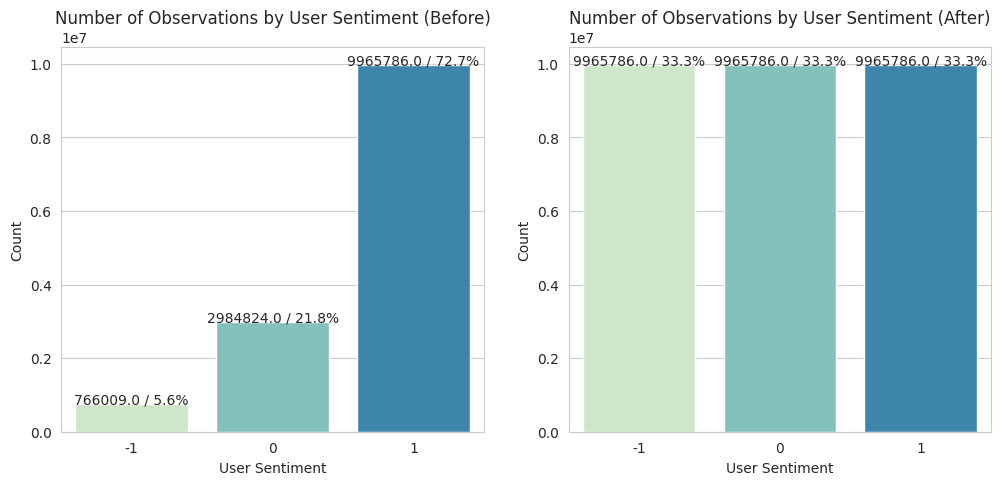

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
sns.set_style("whitegrid")

categorical_countplot(
    data_series=y_train_backup,
    title="Number of Observations by User Sentiment (Before)",
    xlabel="User Sentiment",
    ylabel="Count",
    metric_type="both",
    display_metric_margin=500,
    axis=axis[0]
)

categorical_countplot(
    data_series=y_train,
    title="Number of Observations by User Sentiment (After)",
    xlabel="User Sentiment",
    ylabel="Count",
    metric_type="both",
    display_metric_margin=500,
    axis=axis[1]
)

# 15. Model Building ([menu](#menu)) <a id='m-15'></a>

#### Function Helpers

In [ ]:
# Function: calculate all metrics to evalue model
def evaluate_model(built_model, X_train, X_test, y_train, y_test):
    y_train_pred = built_model.predict(X_train)
    y_test_pred = built_model.predict(X_test)
    print("Report for trainning process:")
    print(classification_report(y_train.values, y_train_pred))
    print("-" * 33)
    print("Report for test process:")
    print(classification_report(y_test.values, y_test_pred))
    pass

## 15.1 Model 1: Logistic Regression ([menu](#menu)) <a id='m-15-1'></a>

### Step 1: Build Model

In [ ]:
# Create and fit model
%%time
lr_model = LogisticRegression(random_state=17, max_iter=1000, multi_class="multinomial", solver="sag").fit(X_train, y_train)

CPU times: user 46min 4s, sys: 1.58 s, total: 46min 6s
Wall time: 45min 54s


### Step 2: Evaluate Model

In [ ]:
# Evaluate model
evaluate_model(lr_model, X_train, X_test, y_train, y_test)

Report for trainning process:
              precision    recall  f1-score   support

          -1       0.96      0.98      0.97   9965786
           0       0.93      0.94      0.93   9965786
           1       0.97      0.94      0.95   9965786

    accuracy                           0.95  29897358
   macro avg       0.95      0.95      0.95  29897358
weighted avg       0.95      0.95      0.95  29897358

---------------------------------
Report for test process:
              precision    recall  f1-score   support

          -1       0.63      0.80      0.71    328924
           0       0.74      0.83      0.78   1277381
           1       0.97      0.92      0.95   4272246

    accuracy                           0.89   5878551
   macro avg       0.78      0.85      0.81   5878551
weighted avg       0.90      0.89      0.90   5878551



## 15.2 Model 2: Naive Bayes ([menu](#menu)) <a id='m-15-2'></a>

### Step 1: Build Model

In [ ]:
# Create and fit model
nb_model = MultinomialNB(alpha=1.0).fit(X_train, y_train)

### Step 2: Evaluate Model

In [ ]:
# Evaluate model
evaluate_model(nb_model, X_train, X_test, y_train, y_test)

Report for trainning process:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     18391
           1       0.98      0.92      0.95     18391

    accuracy                           0.95     36782
   macro avg       0.95      0.95      0.95     36782
weighted avg       0.95      0.95      0.95     36782

---------------------------------
Report for test process:
              precision    recall  f1-score   support

           0       0.39      0.62      0.48       960
           1       0.95      0.88      0.92      7937

    accuracy                           0.85      8897
   macro avg       0.67      0.75      0.70      8897
weighted avg       0.89      0.85      0.87      8897



## 15.3 Model 3: Random Forest ([menu](#menu)) <a id='m-15-3'></a>

### Step 1: Build Model

In [ ]:
# Create and fit model
rf_model = RandomForestClassifier(n_estimators=10, max_depth=30, min_samples_leaf=10, oob_score=True, random_state=17).fit(X_train, y_train)

C:\Programs\anaconda3\envs\data-lab\lib\site-packages\sklearn\ensemble\_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


### Step 2: Evaluate Model

In [ ]:
# Evaluate model
evaluate_model(rf_model, X_train, X_test, y_train, y_test)

Report for trainning process:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79     18391
           1       0.76      0.88      0.82     18391

    accuracy                           0.81     36782
   macro avg       0.81      0.81      0.80     36782
weighted avg       0.81      0.81      0.80     36782

---------------------------------
Report for test process:
              precision    recall  f1-score   support

           0       0.27      0.37      0.31       960
           1       0.92      0.88      0.90      7937

    accuracy                           0.82      8897
   macro avg       0.59      0.62      0.61      8897
weighted avg       0.85      0.82      0.84      8897



### Step 3: Build Model with Hyperparameter Tuning

In [ ]:
# Set up hyper-parameters
rf_params = {
    "max_depth": [10, 30, 50],
    "min_samples_leaf": [10, 50, 100],
    "n_estimators": [10, 50, 100]
}

In [ ]:
# Create the grid search model
rf_gs_model = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring = "f1_weighted"
)

In [ ]:
# Fit model
rf_gs_model.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=30, min_samples_leaf=10,
                                              n_estimators=10, oob_score=True,
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [10, 30, 50],
                         'min_samples_leaf': [10, 50, 100],
                         'n_estimators': [10, 50, 100]},
             scoring='f1_weighted', verbose=1)

In [ ]:
# Print the best estimator
print(rf_gs_model.best_estimator_)

RandomForestClassifier(max_depth=50, min_samples_leaf=10, oob_score=True,
                       random_state=17)


In [ ]:
# Create best model
rf_model_tune = rf_gs_model.best_estimator_

### Step 4: Evaluate Model after Hyperparameter Tuning

In [ ]:
# Evaluate model
evaluate_model(rf_model_tune, X_train, X_test, y_train, y_test)

Report for trainning process:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     18391
           1       0.83      0.91      0.87     18391

    accuracy                           0.87     36782
   macro avg       0.87      0.87      0.86     36782
weighted avg       0.87      0.87      0.86     36782

---------------------------------
Report for test process:
              precision    recall  f1-score   support

           0       0.35      0.40      0.37       960
           1       0.93      0.91      0.92      7937

    accuracy                           0.85      8897
   macro avg       0.64      0.65      0.64      8897
weighted avg       0.86      0.85      0.86      8897



## 15.4 Model 4: XGBoost ([menu](#menu)) <a id='m-15-4'></a>

### Step 1: Build Model

In [ ]:
# Create and fit model
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=40, random_state=17).fit(X_train, y_train)

### Step 2: Evaluate Model

In [ ]:
# Evaluate model
evaluate_model(xgb_model, X_train, X_test, y_train, y_test)

Report for trainning process:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18391
           1       0.99      0.99      0.99     18391

    accuracy                           0.99     36782
   macro avg       0.99      0.99      0.99     36782
weighted avg       0.99      0.99      0.99     36782

---------------------------------
Report for test process:
              precision    recall  f1-score   support

           0       0.52      0.49      0.50       960
           1       0.94      0.95      0.94      7937

    accuracy                           0.90      8897
   macro avg       0.73      0.72      0.72      8897
weighted avg       0.89      0.90      0.89      8897



### Step 3: Build Model with Hyperparameter Tuning

In [ ]:
# Set up hyper-parameters
xgb_params = {
    "learning_rate": [0.001, 0.01],
    "max_depth":[ 5, 10],
    "n_estimators": [50, 100]
}

In [ ]:
# Create the grid search model
xgb_gs_model = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring = "f1_weighted"
)

In [ ]:
# Fit model
xgb_gs_model.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, m...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=40,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=17, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01], 'max_depth': [5, 10],
                         'n_estimators': [50, 100]},
             scoring='f1_weighted', verbose=1)

In [ ]:
# Print the best estimator
print(xgb_gs_model.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=17, ...)


In [ ]:
# Create best model
xgb_model_tune = xgb_gs_model.best_estimator_

### Step 4: Evaluate Model after Hyperparameter Tuning

In [ ]:
# Evaluate model
evaluate_model(xgb_model_tune, X_train, X_test, y_train, y_test)

Report for trainning process:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     18391
           1       0.86      0.83      0.84     18391

    accuracy                           0.85     36782
   macro avg       0.85      0.85      0.85     36782
weighted avg       0.85      0.85      0.85     36782

---------------------------------
Report for test process:
              precision    recall  f1-score   support

           0       0.29      0.62      0.39       960
           1       0.95      0.81      0.87      7937

    accuracy                           0.79      8897
   macro avg       0.62      0.72      0.63      8897
weighted avg       0.88      0.79      0.82      8897



# 16. Compare Models ([menu](#menu)) <a id='m-16'></a>

In [ ]:
# Summay all models
dict_models = {
    "Logistic Regression": lr_model,
    "Naive Bayes": nb_model,
    "Random Forest": rf_model,
    "Random Forest Tune": rf_model_tune,
    "XGBoost": xgb_model,
    "XGBoost Tune": xgb_model_tune

}

df_models_summary = pd.DataFrame({
    "model_name": dict_models.keys(),
    "accuracy": list(map(lambda m: accuracy_score(y_test.values, m.predict(X_test)), dict_models.values())),
    "precision": list(map(lambda m: precision_score(y_test.values, m.predict(X_test), average="weighted"), dict_models.values())),
    "recall": list(map(lambda m: recall_score(y_test.values, m.predict(X_test), average="weighted"), dict_models.values())),
    "f1_score": list(map(lambda m: f1_score(y_test.values, m.predict(X_test), average="weighted"), dict_models.values())),
    "roc_auc": list(map(lambda m: roc_auc_score(y_test.values, m.predict(X_test)), dict_models.values())),
})

In [ ]:
# Print the modelssummary
df_models_summary.round(2)

# 17. Save Best Model ([menu](#menu)) <a id='m-17'></a>

**Save pickle files:**

In [ ]:
# Function: serialize data to pickle file
def write_file(file_name, data):
    with open(f"{root_path}/{file_name}.pkl", 'wb') as f:
        pickle.dump(data, f)

# Function: deserialize data from pickle file
def read_file(file_name):
    with open(f"{root_path}/{file_name}.pkl", 'rb') as f:
        return pickle.load(f)

In [ ]:
write_file("bk_tfidf_vectorizer", tfidf_vectorizer)
write_file("bk_data_cleaned", df)
write_file("bk_best_model", xgb_model)